# Task 2

There are results of A/B test with two sets of special offers for the user groups. We know that ARPU of the test group is 5% higher than of the control group. There were 1928 paying players of 202103 players in the control group and 1805 of 202667 in the test group.<br/>Which set of special offers is better? Which metrics should be analysed for the decision and how?

We should check if the difference between ARPU rates in the groups is significant. Also we should examine conversion rates and ARPPU.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# loading the dataset
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')

In [3]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Let's look at the purchase distribution in the groups

In [4]:
df.query('testgroup == "a" and revenue != 0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [5]:
df.query('testgroup == "b" and revenue != 0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

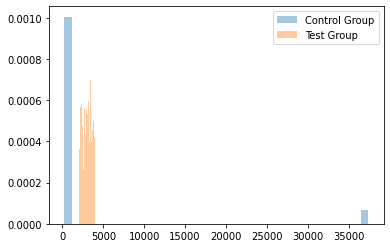

In [6]:
plt.hist(df.query('testgroup == "a" and revenue != 0').revenue, bins = 40, density = True, alpha = 0.4, label='Control Group')
plt.hist(df.query('testgroup == "b" and revenue != 0').revenue, bins = 40, density = True, alpha = 0.4, label='Test Group')
plt.legend()

We can see that purchase patterns are different in the groups. Most purchases in the test group are from 2000 to 4000, whereas most values in the control group are less than 1000, although there are outliers greater than 30000. We should figure out where such values came from. It could be because of payment structure/conditions or because of some technical issue. For the time being just keep in mind those outliers. 

In [7]:
# calculating ARPU for the groups and their difference
arpu_control = df.query('testgroup == "a"').revenue.mean().round(2)
arpu_test = df.query('testgroup == "b"').revenue.mean().round(2)
print(f'ARPU Control: {arpu_control}')
print(f'ARPU Test: {arpu_test}')
print(f'ARPU Diff: {(arpu_test-arpu_control)/arpu_control:.2%}')

ARPU Control: 25.41
ARPU Test: 26.75
ARPU Diff: 5.27%


In [8]:
# using Mann-Whitney test
statistic, pvalue = stats.mannwhitneyu(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)
print(f'p-value: {pvalue:.2f}')

p-value: 0.03


According to the Mann-Whitney test, we can say that ARPU in the test group is significantly higher than in the control group. Let's check this with the help of bootstrap, using the function below:

In [9]:
def get_bootstrap(col1, col2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """
        col1: first sample values
        col2: second sample values
        boot_it: number of bootstrap subsamples
        statistic: statistical value
        bootstrap_conf_level: confidence level
    """
    boot_len = max(len(col1), len(col2))
    boot_data = []
    # extracting subsamples
    for i in range(boot_it):
        samples_1 = col1.sample(boot_len, replace=True).values
        samples_2 = col2.sample(boot_len, replace=True).values
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # making a plot
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, "ci": ci, "p_value": p_value}

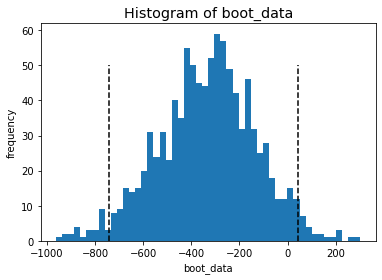

In [10]:
booted_data = get_bootstrap(df.query('testgroup == "a" and revenue != 0').revenue,
                            df.query('testgroup == "b" and revenue != 0').revenue)

In [11]:
booted_data["p_value"]

0.09559970510446927

In [12]:
booted_data["ci"]

,0
0.025,-743.215223
0.975,41.512915


p > 0.05 and 0 is within the confidence interval. Thus we cannot reject the zero hypothesis about absence of significant difference between the groups. Let's remove the outliers from the control group and try to use the bootstrap again:

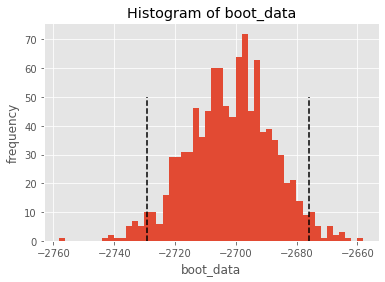

In [13]:
booted_data = get_bootstrap(df.query('testgroup == "a" and 0 < revenue < 30000').revenue,
                            df.query('testgroup == "b" and revenue != 0').revenue)

In [14]:
booted_data["p_value"]

0.0

In [15]:
booted_data["ci"]

,0
0.025,-2729.125485
0.975,-2675.808324


p < 0.05, 0 not in the confidence interval. We've got the opposite result and we can reject the zero hypothesis about absence of significant difference between the groups. We should analyse other metrics.

In [16]:
# calculating total number of users and number of paying users in the groups, calculating conversion
clients_control = df.query('testgroup == "a" and revenue != 0').shape[0]
clients_test = df.query('testgroup == "b" and revenue != 0').shape[0]
users_control = df.query('testgroup == "a"').shape[0]
users_test = df.query('testgroup == "b"').shape[0]
conversion_control = clients_control/users_control
conversion_test = clients_test/users_test
print(f'Control conversion: {conversion_control:.2%}\nTest conversion: {conversion_test:.2%}')

Control conversion: 0.95%
Test conversion: 0.89%


The conversion rate in the test group is smaller. Let's find out if this difference is significant, using the chi-squared test.

In [17]:
stat, p, dof, expected = stats.chi2_contingency([[clients_control, clients_test], [users_control, users_test]])
print(p)

0.03824373651044171


p < 0.05, that means that the difference is significant. Let's use the test again without the outliers in the control group.

In [18]:
clients_control2 = df.query('testgroup == "a" and 0 < revenue < 30000').shape[0]
stat, p, dof, expected = stats.chi2_contingency([[clients_control2, clients_test], [users_control, users_test]])
print(p)

0.9468757370621719


p > 0.05, the difference is not significant. Let's look at ARPPU in the groups (without outliers in the control group):

In [19]:
arppu_control = df.query('testgroup == "a" and 0 < revenue < 30000').revenue.mean().round(2)
arppu_test = df.query('testgroup == "b" and revenue !=0').revenue.mean().round(2)
print(f'ARPPU Control: {arppu_control}\nARPPU Test: {arppu_test}')

ARPPU Control: 302.46
ARPPU Test: 3003.66


Text(0.5, 6.79999999999999, 'Test group')

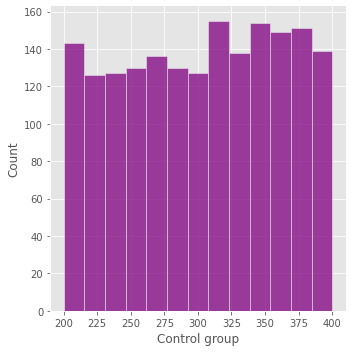

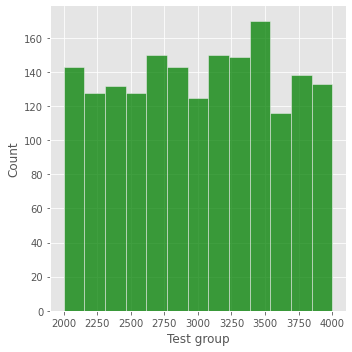

In [20]:
sns.displot(df.query('testgroup == "a" and 0 != revenue < 30000').revenue, color='purple')
plt.xlabel('Control group')
sns.displot(df.query('testgroup == "b" and revenue != 0').revenue, color='green')
plt.xlabel('Test group')

In [21]:
# examining outliers
df.query('testgroup == "a" and revenue > 30000').revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

There are 123 users with anomalous purchases. We should find out how this data appeared in the A/B test.

## Results
* We get opposite results depending on whether we include outliers in the control group or not. So, first of all we should examine this anomalous data and find out its source.
* The test group has a smaller conversion rate than the control group, but its **ARPPU** is higher (both differences are significant).
* If it turns out that the outliers are due to some error, then we can assume that **ARPU** in the test group is significantly higher by 5% (according to Mann-Whitney and bootstrap tests). That means we can use special offers from the test group. Otherwise, we should examine the data source more carefully.